<h3> Instaling Depdencies </h3>
<br>
<p> let's install the required dependencies for the project </p>

In [20]:
!pip install lxml

<h3> Importing Dependencies </h3>
<br>
<p> For this particular project we are going to have following dependencies so far: </p>
    <ul>
        <li> opencv </li>
        <li> xml </li>
        <li> numpy </li>
        <li> tensorflow </li>
        <li> sklearn </li>
    </ul>

In [33]:
import cv2
import xml.etree.ElementTree as ET
import os
import numpy as np 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.applications.efficientnet import EfficientNetB0
from PIL import Image

<h3> Data Preprocessing  </h3>

<p>&nbsp; Here we are going to resize image to a standard size so that we can use it to resize the coordinates as well </p>

In [22]:
def get_image_bound_it(path,display_flag):
    img=cv2.imread(path)

    #Let's scale image down and also adjust its cordinate accordingly:
    x_=img.shape[1]
    y_=img.shape[0]

    target_size=500
    img=cv2.resize(img,(target_size,target_size))
    xscale=target_size/x_
    yscale=target_size/y_
    # We are going to use xcale and yscale to get the new cordinate by rounding off with this product value 

    tree = ET.parse(path.replace('.jpg','.xml'))
    root = tree.getroot()

    boxes=[]
    for child in root.findall('object'):
        #print(child.find('name').text)
        boxes.append([float(float(float(child.find('bndbox/xmin').text)*xscale)/img.shape[1]),float(float(float(child.find('bndbox/ymin').text)*yscale)/img.shape[0]),float(float(float(child.find('bndbox/xmax').text)*xscale)/img.shape[1]),float(float(float(child.find('bndbox/ymax').text)*yscale)/img.shape[0])])
        label_name=((path.split('/')[-1]).split('.')[0]).split('_')[0]
        print(label_name)
        #boxes.append([float(np.round(float(child.find('bndbox/xmin').text)*xscale)),float(np.round(float(child.find('bndbox/ymin').text)*yscale)),float(np.round(float(child.find('bndbox/xmax').text)*xscale)),float(np.round(float(child.find('bndbox/ymax').text)*yscale))])


    if display_flag==1:
        try:
            cv2.imshow('Image',img)
            cv2.waitKey(0)
        except:
            pass
        
        for box in boxes:
            color = (255, 0, 0)
            thickness = 2 
            img=cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,thickness)
        try:
            cv2.imshow("Image",img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        except:
            pass
    return np.array(img),np.array(boxes),label_name


<h4> Batch Data Processing </h4>

In [23]:
images_list=[]
labels_list=[]
names_list=[]
op_list=['orange','apple','mixed','banana']
for file in os.listdir('train_zip/train'):
    if file.endswith('.jpg'):
        X,Y,Y_name=get_image_bound_it('train_zip/train/'+file,0)
        if len(Y)==1:
            images_list.append(X)
            labels_list.append(Y)
            names_list.append(op_list.index(Y_name))
    
images_list=np.array(images_list)
labels_list=np.array(labels_list)
layers=tf.keras.layers.CategoryEncoding(num_tokens=len(list(set(names_list))), output_mode="one_hot")
names_list=np.array(layers(names_list))

print(labels_list)

apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
apple
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana
banana

In [24]:
X,Xtest,Y,Ytest,YC,YCtest=train_test_split(images_list,labels_list,names_list)

In [25]:
inputCustom=tf.keras.layers.Input(shape=(500,500,3))
model=EfficientNetB0(include_top=False,input_tensor=inputCustom,weights='imagenet')

for i in range(int(len(model.layers) * 0.45)):
    model.layers[i].trainable = False

#model.trainable = False


avg_pool_b_norm = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
flatten = tf.keras.layers.BatchNormalization()(avg_pool_b_norm)


x=tf.keras.layers.Dense(256,activation='relu')(flatten)
x=tf.keras.layers.Dense(128,activation='relu')(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
output=tf.keras.layers.Dense(4,activation='sigmoid',name="bounding_box")(x)



x_c=tf.keras.layers.Dense(256,activation='relu')(flatten)
x_c=tf.keras.layers.Dense(128,activation='relu')(x_c)
x_c=tf.keras.layers.Dense(64,activation='relu')(x_c)
output_c=tf.keras.layers.Dense(4,activation='sigmoid',name="class_label")(x_c)

losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

opt = tf.keras.optimizers.Adam(lr=0.01)

model=tf.keras.Model(inputs=inputCustom,outputs=(output,output_c))
model.compile(optimizer=opt,
            loss=losses,
            metrics=['mse'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 500, 500, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 500, 500, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

In [26]:
trainTargets = {
	"class_label": YC,
	"bounding_box": Y
}

testTargets = {
	"class_label": YCtest,
	"bounding_box": Ytest
}

In [27]:
model.fit(X, trainTargets,validation_data=(Xtest, testTargets),epochs=200,batch_size=32)

Epoch 1/200
4/4 [==============================] - 49s 8s/step - loss: 1.3068 - bounding_box_loss: 0.0698 - class_label_loss: 1.2370 - bounding_box_mse: 0.0731 - class_label_mse: 0.2116 - val_loss: 1.0436 - val_bounding_box_loss: 0.0442 - val_class_label_loss: 0.9995 - val_bounding_box_mse: 0.0449 - val_class_label_mse: 0.2024
Epoch 2/200
4/4 [==============================] - 39s 11s/step - loss: 0.1502 - bounding_box_loss: 0.0274 - class_label_loss: 0.1228 - bounding_box_mse: 0.0284 - class_label_mse: 0.0630 - val_loss: 0.7548 - val_bounding_box_loss: 0.0240 - val_class_label_loss: 0.7308 - val_bounding_box_mse: 0.0242 - val_class_label_mse: 0.1601
Epoch 3/200
4/4 [==============================] - 34s 10s/step - loss: 0.0677 - bounding_box_loss: 0.0309 - class_label_loss: 0.0368 - bounding_box_mse: 0.0316 - class_label_mse: 0.0502 - val_loss: 0.6710 - val_bounding_box_loss: 0.0236 - val_class_label_loss: 0.6474 - val_bounding_box_mse: 0.0237 - val_class_label_mse: 0.1407
Epoch 4/200

In [30]:
model.save_weights('test_detector.h5')

1/1 [==============================] - 0s 122ms/step
apple


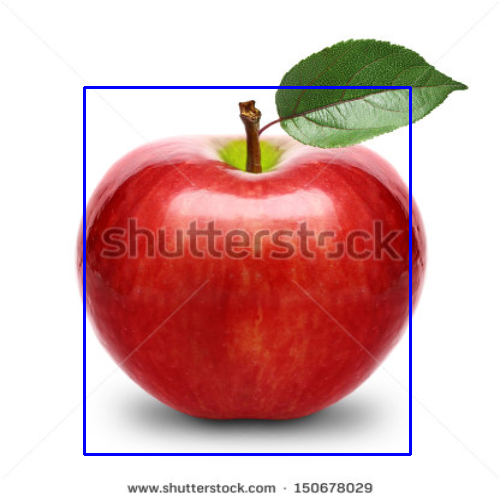

In [36]:
path=input('Enter Image URL: ')
X_infer=np.array(cv2.resize(cv2.imread(path),(500,500)))
X_infer=X_infer.reshape(1,X_infer.shape[0],X_infer.shape[1],X_infer.shape[2])
pred=list(model.predict(X_infer))
pred_c=np.argmax(list(pred[1]))

print(op_list[pred_c])
pred=pred[0][0]
pred=[int(i*500) for i in pred]
img=cv2.rectangle(cv2.resize(cv2.imread(path),(500,500)),(pred[0],pred[1]),(pred[2],pred[3]),(255,0,0),2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
im_pil